### Train a Recurrent Spiking Neural Networks for Pattern Generation Task

We are going to feed fix-rate Poisson spike trains to a recurrent spiking neural network and train the network to generate a motor pattern. All input, recurrent and output weights are plastic. We are not going to use BPTT (or autograd), but fully online, eligibility-trace based e-prop learning rule.

In [1]:
# Remove 2 comments to train on TPUs at Colab
# import jax.tools.colab_tpu
# jax.tools.colab_tpu.setup_tpu()

import matplotlib.pyplot as plt
from jax import random
import jax.numpy as np
from eprop.dataset import Sinusoids
from eprop.utils import initialize_parameters, mse_loss
from eprop.model import SRNN

In [2]:
####
# Parameters
####
seed    = 42 # deterministic magic
epochs  = 100
n_inp   = 100 # number of input neurons
n_rec   = 100 # number of recurrent neurons
n_out   = 1 # number of output units (non-spiking)
tau_rec = 30e-3 # (sec) membrane voltage decay constant for recurrent layer
tau_out = 30e-3 # (sec) membrane voltage decay constant for output layer
thr     = 0.1 # membrane threshold voltage
gamma   = 0.3 # scaling factor for post-synaptic activity
lr_inp  = 3e-4 # learning rate of input weights
lr_rec  = 5e-4 # learning rate of recurrent weights
lr_out  = 9e-4 # learning rate of output weights
n_t     = 1000 # (ms) motor task duration 
reg     = 1e-4 # firing rate regularization constant
f0      = 5 # (Hz) targeted mean firing rate
w_gain  = 0.01 # initialization factor
dt      = 1e-3 # (sec) simulation time step

# deterministic JAX 
key = random.PRNGKey(seed)

# create dataset
toy_dataset = Sinusoids(key, seq_length=n_t, num_samples=4, num_inputs=n_inp, input_freq=50)

# create network
theta = initialize_parameters(key, n_inp, n_rec, n_out, w_gain)
srnn =  SRNN(n_inp, n_rec, n_out, tau_rec, tau_out, thr,
             gamma, lr_inp, lr_rec, lr_out, n_t, reg, f0, dt)

# training loop
loss_arr = []
for epoch in range(epochs):
    for x,y in zip(toy_dataset.x, toy_dataset.y):

        yhat, traces, reg_term = srnn.forward(theta, x)
        loss   = yhat-y # Scaled derivative of (yhat-y)^2
        grads  = srnn.acc_gradient(loss, traces, reg_term, theta)
        theta  = srnn.upd_weights(theta, grads)
        
    loss_arr.append(mse_loss(yhat,y))
    if epoch%10 == 0:
        print(f'Epoch: [{epoch}/{epochs}] - MSE Loss: {mse_loss(yhat, y):.4f}')

Epoch: [0/100] - MSE Loss: 0.4535
Epoch: [10/100] - MSE Loss: 0.3085
Epoch: [20/100] - MSE Loss: 0.1468
Epoch: [30/100] - MSE Loss: 0.1026
Epoch: [40/100] - MSE Loss: 0.0795
Epoch: [50/100] - MSE Loss: 0.0641
Epoch: [60/100] - MSE Loss: 0.0747
Epoch: [70/100] - MSE Loss: 0.0442
Epoch: [80/100] - MSE Loss: 0.0492
Epoch: [90/100] - MSE Loss: 0.0429


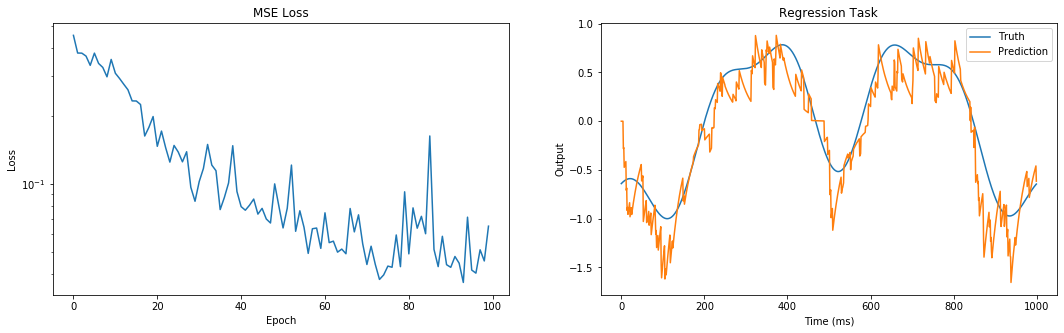

In [3]:
plt.figure(figsize=(18,5))
plt.subplot(121)
plt.title('MSE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.semilogy(np.arange(0,epochs,1),loss_arr)
plt.subplot(122)
plt.title('Regression Task')
plt.xlabel('Time (ms)')
plt.ylabel('Output')
plt.plot(np.arange(0,n_t,1),y, label='Truth')
plt.plot(yhat, label='Prediction')
plt.legend()

In [ ]:
# Well, it works.